In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from synthesizer.conversions import lnu_to_absolute_mag
from unyt import erg, Hz, s  # Ensure unyt package is installed
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import calc_df, get_photometry

# Define input and output paths
input_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/photometry"
output_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/LFs"
os.makedirs(output_dir, exist_ok=True)
#snaps available:
#snap_044, z=2.00 = 2
#snap_052, z=1.48 = 1.5
#snap_060, z=1.05 = 1
#snap_086, z=0.10 = 0.1

# Snapshot data for redshift
redshift_values = {
    'snap_044': (2.00, '044'),
    'snap_052': (1.48, '052'),
    'snap_060': (1.05, '060'),
    'snap_086': (0.10, '086')
}

# Co-moving volume parameters
BoxSize = 25.0  # in Mpc/h, 
little_h = 0.6711
# need to correct comoving volume for lttle h. Boxsize is volume - NEED TO CORRECT FOR REDSHIFT WHEN USING OBSERVED SPECTRA NOT REST FRAME
Vcom=BoxSize/little_h
massBinLimits = np.arange(-24, -16, 0.5)

# Process each file in the directory
for filename in os.listdir(input_dir):
    if filename.endswith("_photometry.hdf5"):
        file_path = os.path.join(input_dir, filename)

        # Process each snapshot
        for snap, (redshift, snap_code) in redshift_values.items():
            # Define output filename based on input filename and snapshot code
            output_filename = f"LF_{filename.replace('_photometry.hdf5', '')}_{snap_code}.txt"
            output_path = os.path.join(output_dir, output_filename)


            with h5py.File(file_path, 'r') as hdf:
                # Access UV luminosity data for this snapshot
                lum_UV1500 = hdf[f'/{snap}/BC03/photometry/luminosity/intrinsic/UV1500'][:]
                lum_UV1500_unyt = lum_UV1500 * erg / (Hz * s)

                # Convert to absolute magnitudes
                abs_mags = lnu_to_absolute_mag(lum_UV1500_unyt)
                abs_mag = abs_mags[0]
                # Calculate luminosity function
                phi, phi_sigma, hist = calc_df(abs_mags, Vcom, massBinLimits)

                # Create DataFrame and save to TXT file
                df = pd.DataFrame({
                    'phi': phi,
                    'phi_sigma': phi_sigma,
                    'hist': hist
                })

                
                df.to_csv(output_path, index=False, sep='\t')

            print(f"Processed {filename} for {snap}, output saved to {output_path}")


Processed IllustrisTNG_1P_p7_2_photometry.hdf5 for snap_044, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p7_2_044.txt
Processed IllustrisTNG_1P_p7_2_photometry.hdf5 for snap_052, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p7_2_052.txt
Processed IllustrisTNG_1P_p7_2_photometry.hdf5 for snap_060, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p7_2_060.txt
Processed IllustrisTNG_1P_p7_2_photometry.hdf5 for snap_086, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p7_2_086.txt
Processed IllustrisTNG_1P_p9_n1_photometry.hdf5 for snap_044, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p9_n1_044.txt
Processed IllustrisTNG_1P_p9_n1_photometry.hdf5 for snap_052, output saved to /disk/xray15/aem2/data/28pams/IllustrisTNG/LFs/LF_IllustrisTNG_1P_p9_n1_052.txt
Processed IllustrisTNG_1P_p9_n1_photometry.hdf5 for snap_060

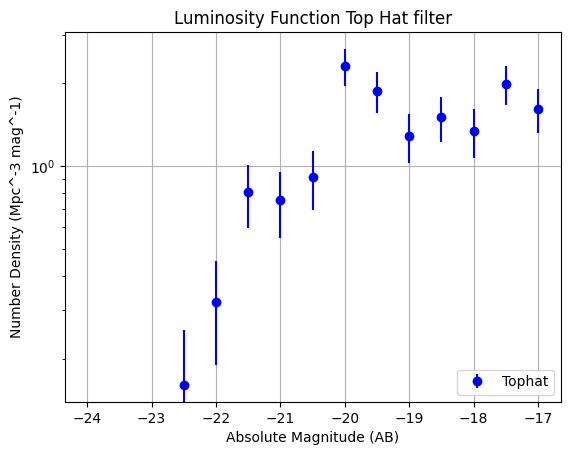

In [11]:
import matplotlib.pyplot as plt
label_025 = 'z = ',
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()